In [1]:
# Imports
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift
from matplotlib import patches
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Network, ready to use
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2, padding_mode='zeros')
        self.pool = nn.MaxPool2d(2, 2) #Pooling 2 by 2, window of 2
        self.conv2 = nn.Conv2d(32, 64, 5 , padding=2, padding_mode='zeros')
        #self.conv3 = nn.Conv2d(64, 128, 5, padding=2, padding_mode='zeros')
        self.fc1 = nn.Linear(64 * 9 * 9, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #x = F.relu(self.conv3(x))
        x = x.view(-1, 64 * 9 * 9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [4]:
# Network loading
net = torch.load("./Saved Models/model_95_test.pt")
net

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=5184, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=2, bias=True)
)

In [5]:
originalImage = cv2.imread('./Images Visages/martin.jpg')
image = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)/255.

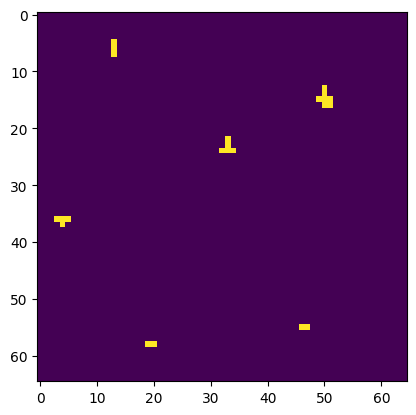

In [6]:
step = 5
size = 36
whole_size = 360
nb_windows = int((whole_size - size + 1)/step)
mat = np.zeros((nb_windows,nb_windows))
cpt = 0
for i in range(nb_windows) :
    for j in range(nb_windows) :
        #cpt+=1
        small_image = image[(step*i):(step*i)+size, (step*j):(step*j)+size]
        #print(cpt, small_image.shape)
        torch_image = torch.from_numpy(small_image).type(torch.FloatTensor)
        torch_image = torch.unsqueeze(torch_image, dim=0)
        torch_image = torch.unsqueeze(torch_image, dim=0)
        outputs = net(torch_image)
        _, predicted = torch.max(outputs.data, 1)
        mat[i][j] = predicted

plt.imshow(mat)

array([[ 88, 268],
       [133, 183],
       [198,  38],
       [ 48,  83],
       [308, 113],
       [293, 248]])

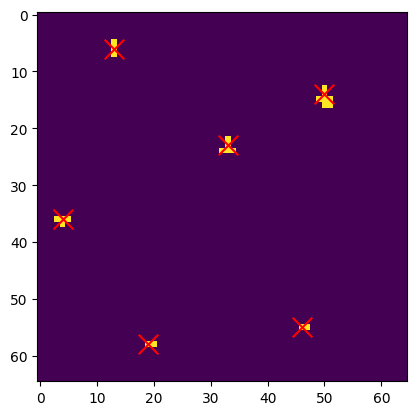

In [7]:
#cluster
array_of_points = [[i, j] for i in range(nb_windows) for j in range(nb_windows) if mat[i][j] == 1]

X = np.array(array_of_points)

clustering = MeanShift(bandwidth=3).fit(X)
centers = clustering.cluster_centers_
#centers = np.reshape(clustering.cluster_centers_, (nb_windows, nb_windows))
centers_faces = centers.astype(int)
plt.imshow(mat)
plt.scatter(centers_faces[:, 1], centers_faces[:, 0], marker="x", color="red", s=200)

#mat_centers = np.zeros((whole_size, whole_size))
#for idx, coord in enumerate(array_of_points):
centers_faces = centers_faces*step + int(size/2)
centers_faces

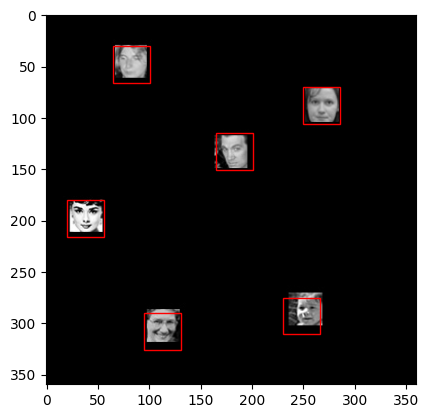

In [8]:
plt.imshow(originalImage)

top_right_corners = np.array(centers_faces)
top_right_corners[:, 1] -= int(size/2)
top_right_corners[:, 0] -= int(size/2)

#plt.scatter(top_right_corners[:, 1], top_right_corners[:, 0], marker="x", color="red", s=200)
ax = plt.gca()
for [x,y] in top_right_corners:
    rect = patches.Rectangle((y,x), size, size, linewidth=1, edgecolor = 'r', facecolor='none')
    ax.add_patch(rect)


# Face recognition of different sizes


Resized Dimensions :  (360, 360)
1
Resized Dimensions :  (288, 288)
2
Resized Dimensions :  (230, 230)
3
Resized Dimensions :  (184, 184)
4


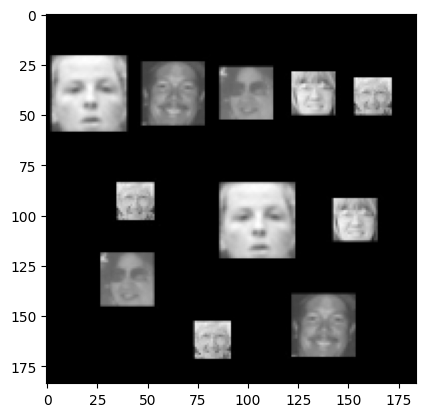

In [9]:
pyramid = []

img = cv2.imread('./Images Visages/Pyramid big faces black.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255.

resized_factors = [1/(0.8 ** i) for i in range(0,4)]

for resized_factor in resized_factors :

  width = int(img.shape[1] / resized_factor)
  height = int(img.shape[0] / resized_factor)
  dim = (width, height)
    
  # resize image
  new_img = cv2.resize(img, dim)
  print('Resized Dimensions : ', new_img.shape)

  plt.imshow(new_img, cmap='gray')
  
  pyramid.append(new_img)
  cv2.waitKey(0)
  cv2.destroyAllWindows()
  print(len(pyramid))


# Get centers of faces detected by going through the pyramid

### Method to find the real centers of faces for each resized factor

In [10]:
def get_face_centers(array_of_points, resised_factor):
    X = np.array(array_of_points)
    clustering = MeanShift(bandwidth=20, max_iter=500).fit(X)
    centers = clustering.cluster_centers_
    centers_faces = centers.astype(int)

    # return the center and the resized_factor
    real_face_size = np.repeat(resised_factor*size, len(centers))
    centers_faces = np.c_[centers_faces, real_face_size]

    return centers_faces

### Going through the pyramid

In [11]:
step = 5
size = 36
whole_size = 360
nb_windows = int((whole_size - size + 1)/step)
mat = np.zeros((360,360))
all_centers = None

for index, resized_factor in enumerate(resized_factors) :
    image = pyramid[index]
    whole_size = image.shape[0]
    nb_windows = int((whole_size - size + 1)/step)
    array_of_points_to_cluster = []

    for i in range(nb_windows) :
        for j in range(nb_windows) :
            center_window_x = step*i+size//2
            center_window_y = step*j+size//2

            small_image = image[(step*i):(step*i)+size, (step*j):(step*j)+size]

            torch_image = torch.from_numpy(small_image).type(torch.FloatTensor)
            torch_image = torch.unsqueeze(torch_image, dim=0)
            torch_image = torch.unsqueeze(torch_image, dim=0)

            outputs = net(torch_image)
            _, predicted = torch.max(outputs.data, 1)

            if predicted == 1:
                array_of_points_to_cluster.append([int(center_window_x * resized_factor), int(center_window_y  * resized_factor)])

    # get the centers_faces with the real size of the face
    current_centers = get_face_centers(array_of_points_to_cluster, resized_factor)
    #print(current_centers)
    all_centers = np.concatenate((all_centers, current_centers), axis=0) if all_centers is not None else current_centers

#print(all_centers)


### Display the centers detected

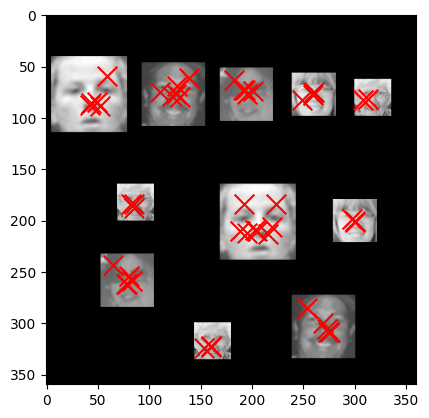

In [12]:
img = cv2.imread('./Images Visages/Pyramid big faces black.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255.
plt.imshow(img, cmap='gray')
plt.scatter(all_centers[:, 1], all_centers[:, 0], marker="x", color="red", s=200)

# 2nd cluster to get only one center for each face

### Method to cluster the centers and return the corresponding size of the face

In [13]:
def get_face_definitive_centers(array_of_points):
    X = np.array(array_of_points)
    clustering = MeanShift(bandwidth=30).fit(X[:,0:2])
    centers = clustering.cluster_centers_
    centers_faces = centers.astype(int)
    sizes = X[:,2]


    # Mapping each cluster with a size

    ## The value is a tuple to compute the avg size
    clusterSizeMap_ = {cluster:[0,0] for cluster in range(len(centers))}

    for point, cluster in enumerate(clustering.labels_):
        clusterSizeMap_[cluster][0] += sizes[point]
        clusterSizeMap_[cluster][1] += 1

    ## Computing the average size value
    clusterSizeMap = {cluster:value[0]//value[1] for cluster, value in clusterSizeMap_.items()}

    return centers_faces, clusterSizeMap

In [14]:
definitive_centers, size_corres = get_face_definitive_centers(all_centers)

### Display the edges of faces

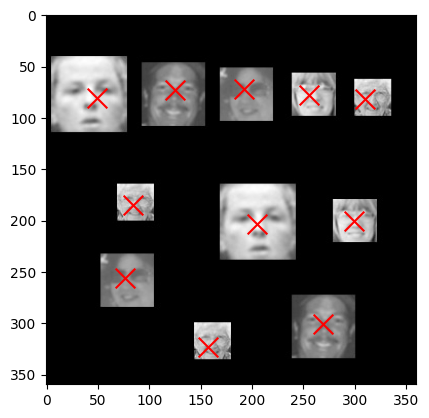

In [15]:
img = cv2.imread('./Images Visages/Pyramid big faces black.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255.
plt.imshow(img, cmap='gray')
plt.scatter(definitive_centers[:, 1], definitive_centers[:, 0], marker="x", color="red", s=200)

# Display the edges of faces

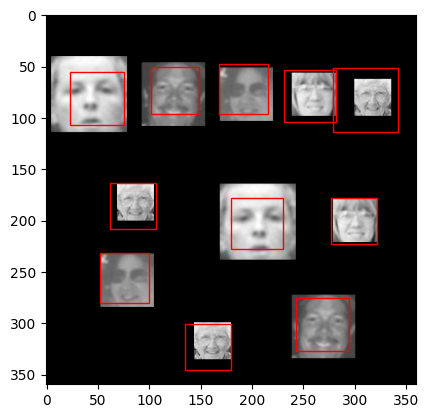

In [16]:
img = cv2.imread('./Images Visages/Pyramid big faces black.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255.
plt.imshow(img, cmap='gray')

top_right_corners = np.array(definitive_centers)
for row in range(len(top_right_corners)):
    size = size_corres[row]
    top_right_corners[row,0] -= int(size/2)
    top_right_corners[row,1] -= int(size/2)

# drawing rectangles
ax = plt.gca()
for row, [x,y] in enumerate(top_right_corners):
    size = size_corres[row]
    rect = patches.Rectangle((y,x), size, size, linewidth=1, edgecolor = 'r', facecolor='none')
    ax.add_patch(rect)